# Custom Loss Comparison on Deep Autoencoder

Using different loss functions to compare the gradient descent and loss of an autoencoder neural network for images.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
from keras import backend as k
import matplotlib.pyplot as plt

### Import Data Generator

In [2]:
from src.AudioDataGenerator import AudioDataGenerator
path_to_mels = '/Users/michaelroth/Documents/Flatiron/Projects/song-similarity-app/data/mels'

Define AudioDataGenerator object

In [3]:
adg = AudioDataGenerator(batch_size=1, input_size=(64,1030), output_size=(64,64), directory=path_to_mels)

Found 322138 files for prediction set


### Import Autoencoder

In [4]:
from src.AttentionAutoEncoder import MelAutoencoder

In [5]:
autoencoder = MelAutoencoder(latent_dim=64, filters=(16,32,64,128), strides=2, pool_size=1, final_image_shape=(32,4,4,128))

In [6]:
autoencoder.build(input_shape=adg.take(0)[0].shape)

In [7]:
autoencoder.summary()

Model: "mel_autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_layer_block (Conv2DL  multiple                 229248    
 ayerBlock)                                                      
                                                                 
 conv2d_transpose_layer_bloc  multiple                 378689    
 k (Conv2DTransposeLayerBloc                                     
 k)                                                              
                                                                 
Total params: 607,937
Trainable params: 606,977
Non-trainable params: 960
_________________________________________________________________


In [8]:
autoencoder.encoder.summary()

Model: "conv2d_layer_block"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  160       
                                                                 
 batch_normalization (BatchN  multiple                 64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           multiple                  4640      
                                                                 
 batch_normalization_1 (Batc  multiple                 128       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           multiple                  18496     
                                                                 
 batch_normalization_2 (Batc  multiple          

In [9]:
autoencoder.decoder.summary()

Model: "conv2d_transpose_layer_block"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             multiple                  133120    
                                                                 
 reshape (Reshape)           multiple                  0         
                                                                 
 conv2d_transpose (Conv2DTra  multiple                 147584    
 nspose)                                                         
                                                                 
 batch_normalization_4 (Batc  multiple                 512       
 hNormalization)                                                 
                                                                 
 conv2d_transpose_1 (Conv2DT  multiple                 73792     
 ranspose)                                                       
                                      

### Define Custom Loss Functions

In [10]:
def mean_squared_error(y_true, y_pred):
    """
    MSE (Mean Square Error) = 1/(number of values) * (y_true - y_pred)**2
    """
    
    y_true = tf.cast(y_true, y_pred.dtype)
    
    return tf.reduce_mean((y_true - y_pred)**2, axis=-1)

def kl_divergence_squared(y_true, y_pred):
    """
    KL Divergence Squared = KLDivergence**2
    
    where KLDivergence = y_true * log(y_true / y_pred)
    """
    
    y_true = tf.cast(y_true, y_pred.dtype)
    y_true = k.clip(y_true, k.epsilon(), 1)
    y_pred = k.clip(y_pred, k.epsilon(), 1)
    
    return tf.reduce_mean(((y_true * tf.math.log(y_true / y_pred))**2), axis=-1)

def psnr(y_true, y_pred):
    """
    PSNR = 20 * log10(y_true_max) - 10 * log10(MSE)
    
    where y_true_max == the maximum possible pixel value for y_true, in this case y_true_max == 1,
    and 20*log(1) == 0, so we can remove this from the formula.
    
    MSE (Mean Square Error) = 1/(number of values) * (y_true - y_pred)**2
    """
    
    mse = mean_squared_error(y_true, y_pred)
    
    psnr = -10 * tf.experimental.numpy.log10(mse)
    
    return psnr

class SSIM(tf.keras.losses.Loss):
    """
    Structural Similarity Index measure (SSIM)
    
    SSIM(y_true, y_pred) = (2 * mean(y_true) * mean(y_pred) + c1) * (2 * covariance(y_true, y_pred) + c2) / (mean(y_true) + mean(y_pred) + c1) * (variance(y_true)**2 + variance(y_pred)**2 + c2)
    
    SSIM is calculated 
    """
    
    def __init__(self, input_shape, kernel_size=10):
        super().__init__()
        self.kernel_size = kernel_size
        self.input_shape = input_shape
        self.conv_layer = layers.Conv2D(filters=1, kernel_size=self.kernel_size, strides=1, padding='same', kernel_initializer=tf.keras.initializers.ones)

        
    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, y_pred.dtype)
        y_true = k.reshape(y_true, shape=self.input_shape)
        y_pred = k.reshape(y_pred, shape=self.input_shape)
        
        mu_1 = self.conv_layer(y_true) / self.kernel_size**2
        mu_2 = self.conv_layer(y_pred) / self.kernel_size**2
        
        mu1_sq = tf.math.square(mu_1)
        mu2_sq = tf.math.square(mu_2)
        mu1_mu2 = mu_1*mu_2
        
        sigma1_sq = self.conv_layer(y_true**2) - mu1_sq
        sigma2_sq = self.conv_layer(y_pred**2) - mu2_sq
        sigma_12 = self.conv_layer(y_pred*y_true) - mu1_mu2
        
        ssim = ((2*mu1_mu2 + 0.0001)*(2*sigma_12 + 2.7e-08))/((mu1_sq + mu2_sq + 0.0001)*(sigma1_sq + sigma2_sq + 2.7e-08))
        
        return ssim
    
    def ssim_invert(self, y_true, y_pred):
        
        return -self.call(y_true, y_pred)
    
    def ssim(self, y_true, y_pred):
        
        return self.call(y_true, y_pred)

class WindowLoss(tf.keras.losses.Loss):
    
    def __init__(self, input_shape, loss_function, kernel_size=10):
        super().__init__()
        
        self.input_shape = input_shape
        self.loss = loss_function
        self.kernel_size = kernel_size
        self.conv_layer = layers.Conv2D(filters=1, kernel_size=kernel_size, strides=1, padding='same', kernel_initializer=tf.keras.initializers.ones)

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, y_pred.dtype)
        y_true = k.reshape(y_true, shape=self.input_shape)
        y_pred = k.reshape(y_pred, shape=self.input_shape)
        
        window_loss = self.conv_layer(tf.expand_dims(self.loss(y_true, y_pred), axis=-1)) / self.kernel_size**2
        return window_loss
    
    def preview(self, y_true, y_pred):
        
        return self.call(y_true, y_pred)

## Define Model Hyperparameters

In [11]:
sample_size = 128000
batch_size = 32
image_size = (64,64)
input_shape = (batch_size, *image_size, 1)
latent_dimensions = 64
convolutional_filters = (16,32,64,128)
encoded_image_shape = (batch_size, 
                       image_size[0]//2**len(convolutional_filters), 
                       image_size[1]//2**len(convolutional_filters), 
                       convolutional_filters[-1])

## Setup SSIM metric

In [12]:
ssim_metric = SSIM(input_shape=(batch_size,*image_size,1))

## Setup Training and Testing Data Generator

In [13]:
train_adg = AudioDataGenerator(batch_size=batch_size, input_size=(64,1030), output_size=image_size, directory=path_to_mels, shuffle=True, sample_size=sample_size, train_test_split=True, test_size=0.2)

Found 102400 files for training set
Found 25600 files for testing set


# Train Autoencoder using Mean Squared Error

In [14]:
def build_autoencoder(latent_dim, filters, final_image_shape, loss, strides=2, pool_size=1):
    autoencoder = MelAutoencoder(latent_dim=latent_dim, filters=filters, strides=strides, pool_size=pool_size, final_image_shape=final_image_shape)
    autoencoder.compile(optimizer='adam', loss=loss, metrics=[mean_squared_error, kl_divergence_squared, ssim_metric.ssim])
    
    return autoencoder

In [15]:
autoencoder_mse = build_autoencoder(latent_dim=latent_dimensions, 
                                    filters=convolutional_filters, 
                                    final_image_shape=encoded_image_shape, 
                                    loss=mean_squared_error)


In [16]:
autoencoder_mse.fit(train_adg.train, epochs=10, validation_data=train_adg.test)

Epoch 1/10


2022-09-28 18:54:47.674263: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


3200/3200 [==============================] - 275s 86ms/step - loss: 0.0119 - mean_squared_error: 0.0119 - kl_divergence_squared: 0.0134 - ssim: 0.7679 - val_loss: 0.0086 - val_mean_squared_error: 0.0086 - val_kl_divergence_squared: 0.0110 - val_ssim: 0.8016
Epoch 2/10
3200/3200 [==============================] - 272s 85ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - kl_divergence_squared: 0.0109 - ssim: 0.8027 - val_loss: 0.0078 - val_mean_squared_error: 0.0078 - val_kl_divergence_squared: 0.0103 - val_ssim: 0.8166
Epoch 3/10
3200/3200 [==============================] - 269s 84ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - kl_divergence_squared: 0.0096 - ssim: 0.8152 - val_loss: 0.0077 - val_mean_squared_error: 0.0077 - val_kl_divergence_squared: 0.0089 - val_ssim: 0.8219
Epoch 4/10
3200/3200 [==============================] - 269s 84ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - kl_divergence_squared: 0.0093 - ssim: 0.8200 - val_loss: 0.0073 - val_mean_squared_erro

## Evaluate Mean Square Error Autoencoder

In [17]:
def evaluate_reconstruction(image, reconstruction):
    input_shape = (1, *image_size, 1)
    ssim_test = SSIM(input_shape=input_shape)
    print('Mean Squared Error', np.mean(mean_squared_error(test_img, reconstruction)))
    print('KL Divergence Squared', np.mean(kl_divergence_squared(test_img, reconstruction)))
    print('SSIM', np.mean(ssim_test.ssim(test_img, reconstruction)))
    print('PSNR', np.mean(psnr(test_img, reconstruction)))

    fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(20,20))
    
    ax[0,0].set_title('Original')
    ax[0,0].imshow(test_img[0])
    
    ax[0,1].set_title('Reconstruction')
    ax[0,1].imshow(reconstruction[0])
    
    ax[0,2].set_title('SSIM')
    ax[0,2].imshow(ssim_test.ssim(test_img, reconstruction)[0])
    
    ax[1,0].set_title('Mean Squared Error')
    ax[1,0].imshow(mean_squared_error(test_img, reconstruction)[0])
    
    ax[1,1].set_title('KL Divergence Squared')
    ax[1,1].imshow(kl_divergence_squared(test_img, reconstruction)[0])
    
    ax[1,2].set_title('PSNR')
    ax[1,2].imshow(psnr(test_img, reconstruction)[0])
    
    ax[2,0].set_title('Mean Squared Error - Windowed')
    mse_window = WindowLoss(input_shape=input_shape, loss_function=mean_squared_error)
    ax[2,0].imshow(mse_window.preview(test_img, reconstruction)[0])
    
    ax[2,1].set_title('KL Divergence Squared - Windowed')
    kl_window = WindowLoss(input_shape=input_shape, loss_function=kl_divergence_squared)
    ax[2,1].imshow(kl_window.preview(test_img, reconstruction)[0])
    
    ax[2,2].set_title('PSNR - Windowed')
    psnr_window = WindowLoss(input_shape=input_shape, loss_function=psnr)
    ax[2,2].imshow(psnr_window.preview(test_img, reconstruction)[0])

Mean Squared Error 0.00961555
KL Divergence Squared 0.012101166
SSIM 0.9120615
PSNR 26.307726


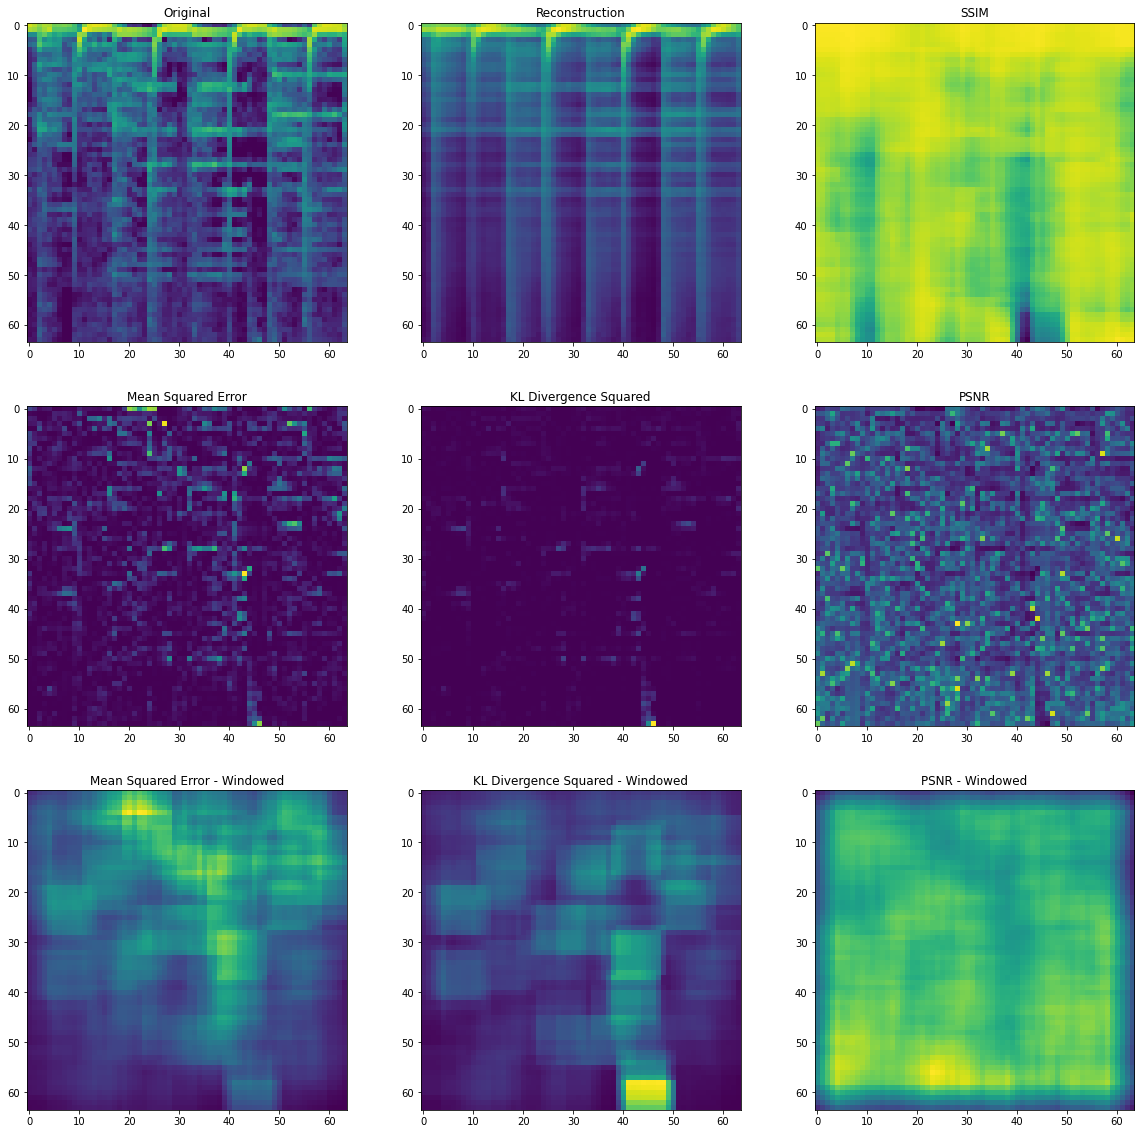

In [18]:
test_img = adg.take(0)[0]
reconstruction_mse = autoencoder_mse(test_img)

evaluate_reconstruction(test_img, reconstruction_mse)

# Train Autoencoder using KL Divergence Squared

In [19]:
autoencoder_kld = build_autoencoder(latent_dim=latent_dimensions, 
                                    filters=convolutional_filters, 
                                    final_image_shape=encoded_image_shape, 
                                    loss=kl_divergence_squared)


In [20]:
autoencoder_kld.fit(train_adg.train, epochs=10, validation_data=train_adg.test)

Epoch 1/10
3200/3200 [==============================] - 266s 83ms/step - loss: 0.0066 - mean_squared_error: 0.0331 - kl_divergence_squared: 0.0066 - ssim: 0.6953 - val_loss: 0.0060 - val_mean_squared_error: 0.0197 - val_kl_divergence_squared: 0.0060 - val_ssim: 0.7445
Epoch 2/10
3200/3200 [==============================] - 265s 83ms/step - loss: 0.0056 - mean_squared_error: 0.0219 - kl_divergence_squared: 0.0056 - ssim: 0.7186 - val_loss: 0.0057 - val_mean_squared_error: 0.0180 - val_kl_divergence_squared: 0.0057 - val_ssim: 0.7549
Epoch 3/10
3200/3200 [==============================] - 263s 82ms/step - loss: 0.0054 - mean_squared_error: 0.0198 - kl_divergence_squared: 0.0054 - ssim: 0.7242 - val_loss: 0.0056 - val_mean_squared_error: 0.0161 - val_kl_divergence_squared: 0.0056 - val_ssim: 0.7612
Epoch 4/10
3200/3200 [==============================] - 262s 82ms/step - loss: 0.0053 - mean_squared_error: 0.0193 - kl_divergence_squared: 0.0053 - ssim: 0.7247 - val_loss: 0.0053 - val_mean_s

# Evaluate Autoencoder Trained on KL Divergence Squared

Mean Squared Error 0.017691717
KL Divergence Squared 0.00653781
SSIM 0.841732
PSNR 23.37274


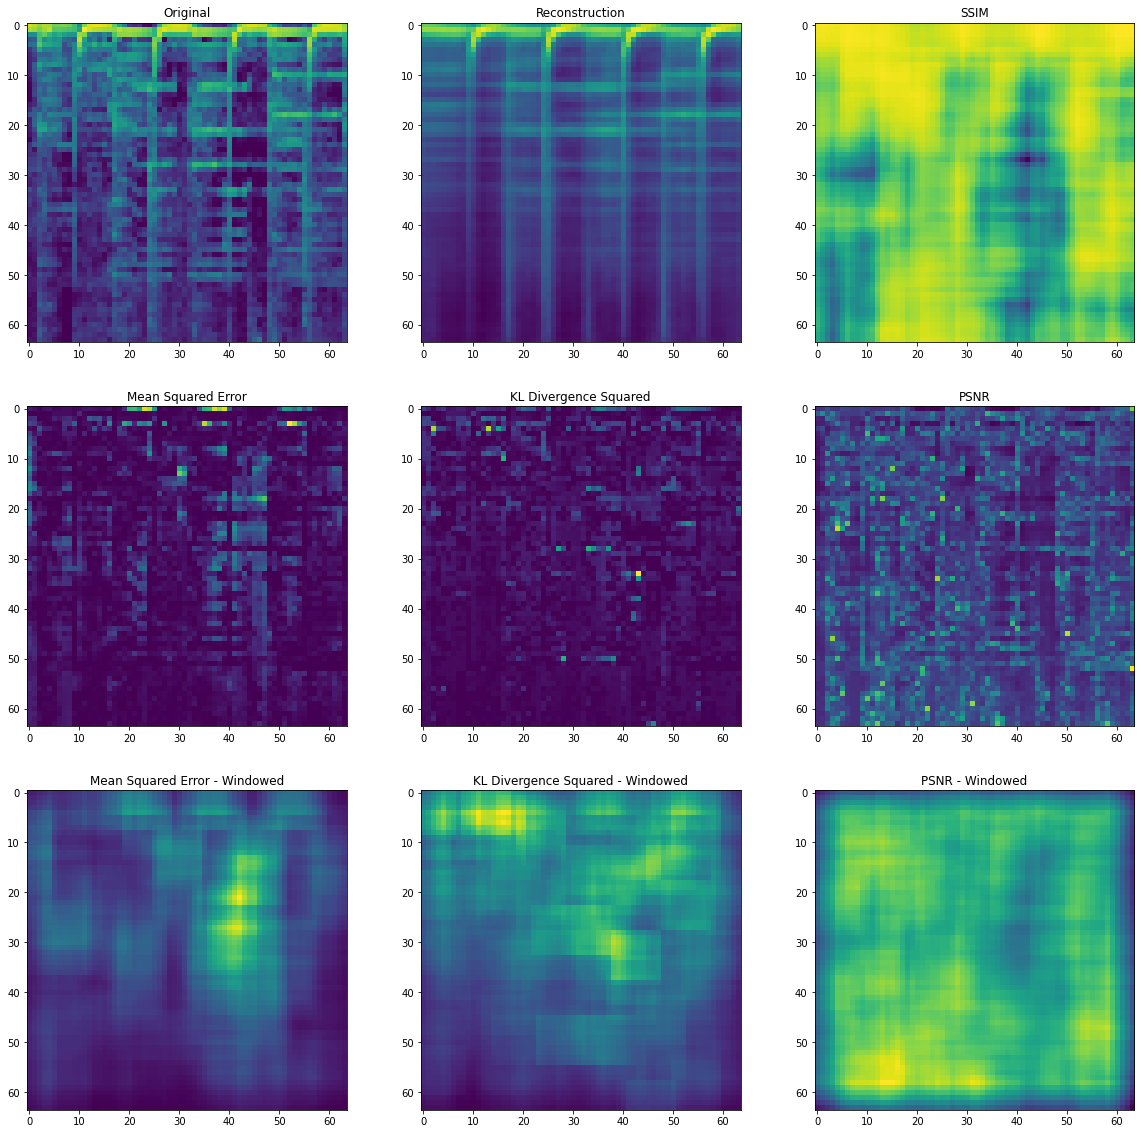

In [21]:
reconstruction_kld = autoencoder_kld(test_img)

evaluate_reconstruction(test_img, reconstruction_kld)

# Train Autoencoder using SSIM

In [22]:
autoencoder_ssim = build_autoencoder(latent_dim=latent_dimensions, 
                                    filters=convolutional_filters, 
                                    final_image_shape=encoded_image_shape, 
                                    loss=ssim_metric.ssim_invert)


In [23]:
autoencoder_ssim.fit(train_adg.train, epochs=10, validation_data=train_adg.test)

Epoch 1/10
3200/3200 [==============================] - 383s 120ms/step - loss: -0.7962 - mean_squared_error: 0.0206 - kl_divergence_squared: 0.0121 - ssim: 0.7962 - val_loss: -0.8380 - val_mean_squared_error: 0.0119 - val_kl_divergence_squared: 0.0097 - val_ssim: 0.8380
Epoch 2/10
3200/3200 [==============================] - 383s 120ms/step - loss: -0.8450 - mean_squared_error: 0.0113 - kl_divergence_squared: 0.0106 - ssim: 0.8450 - val_loss: -0.7543 - val_mean_squared_error: 0.0175 - val_kl_divergence_squared: 0.0548 - val_ssim: 0.7543
Epoch 3/10
3200/3200 [==============================] - 382s 119ms/step - loss: -0.8559 - mean_squared_error: 0.0101 - kl_divergence_squared: 0.0101 - ssim: 0.8559 - val_loss: -0.8425 - val_mean_squared_error: 0.0096 - val_kl_divergence_squared: 0.0089 - val_ssim: 0.8425
Epoch 4/10
3200/3200 [==============================] - 385s 120ms/step - loss: -0.8611 - mean_squared_error: 0.0097 - kl_divergence_squared: 0.0102 - ssim: 0.8611 - val_loss: -0.8642 

# Evaluate Autoencoder train on SSIM

Mean Squared Error 0.013979493
KL Divergence Squared 0.013541532
SSIM 0.9033689
PSNR 25.560173


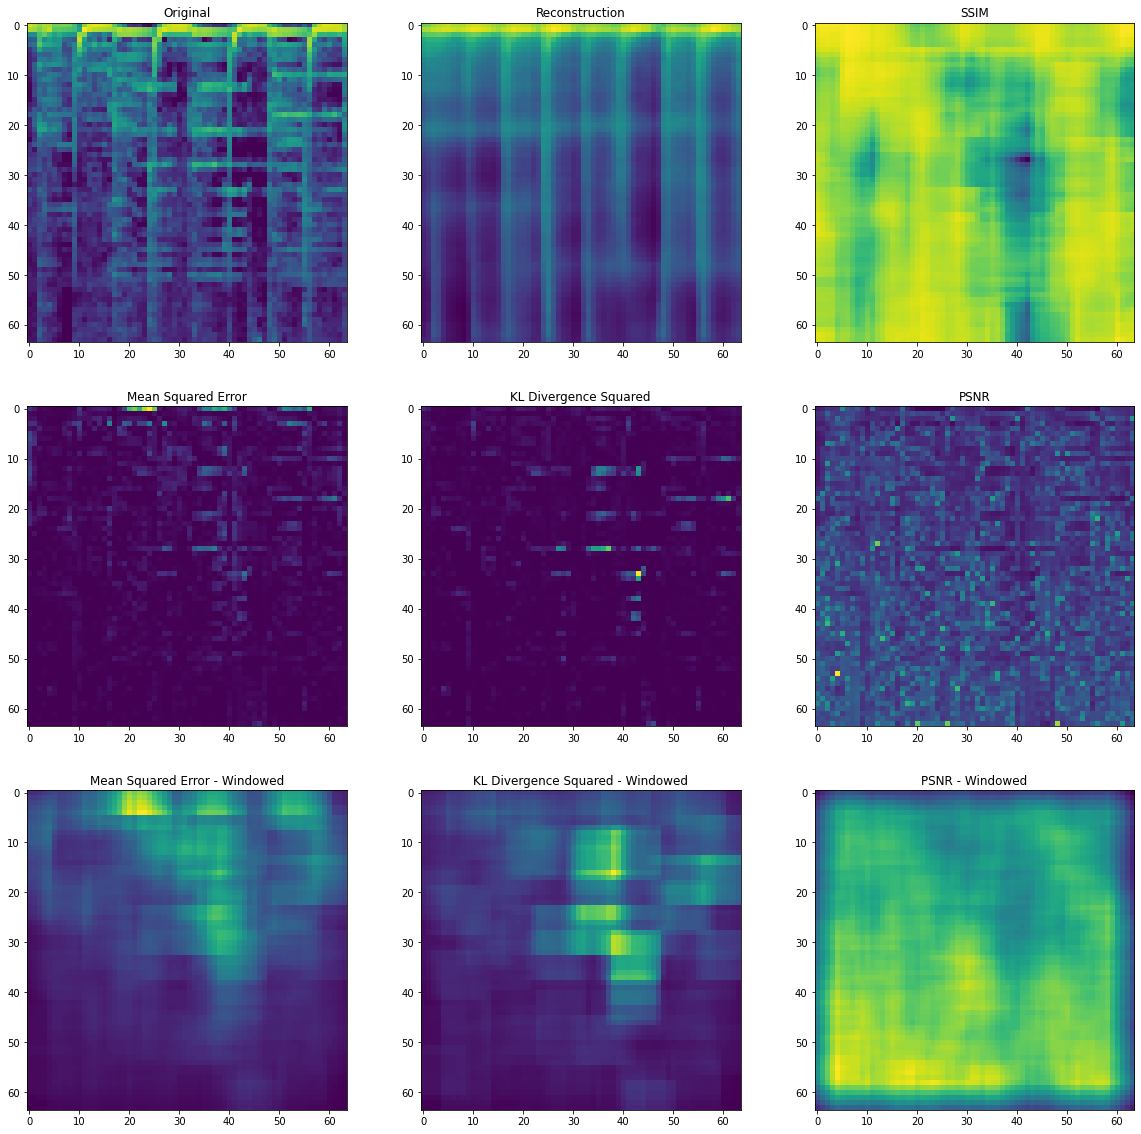

In [24]:
reconstruction_ssim = autoencoder_ssim(test_img)

evaluate_reconstruction(test_img, reconstruction_ssim)

# Train Autoencoder using Windowed MSE

In [25]:
mse_window = WindowLoss(input_shape=input_shape, loss_function=mean_squared_error)
autoencoder_mse_window = build_autoencoder(latent_dim=latent_dimensions, 
                                    filters=convolutional_filters, 
                                    final_image_shape=encoded_image_shape, 
                                    loss=mse_window)


In [26]:
autoencoder_mse_window.fit(train_adg.train, epochs=10, validation_data=train_adg.test)

Epoch 1/10
3200/3200 [==============================] - 289s 90ms/step - loss: 0.0109 - mean_squared_error: 0.0122 - kl_divergence_squared: 0.0139 - ssim: 0.7650 - val_loss: 0.0087 - val_mean_squared_error: 0.0097 - val_kl_divergence_squared: 0.0149 - val_ssim: 0.7787
Epoch 2/10
3200/3200 [==============================] - 288s 90ms/step - loss: 0.0081 - mean_squared_error: 0.0090 - kl_divergence_squared: 0.0107 - ssim: 0.8005 - val_loss: 0.0072 - val_mean_squared_error: 0.0081 - val_kl_divergence_squared: 0.0094 - val_ssim: 0.8227
Epoch 3/10
3200/3200 [==============================] - 286s 89ms/step - loss: 0.0075 - mean_squared_error: 0.0083 - kl_divergence_squared: 0.0099 - ssim: 0.8097 - val_loss: 0.0071 - val_mean_squared_error: 0.0079 - val_kl_divergence_squared: 0.0084 - val_ssim: 0.8256
Epoch 4/10
3200/3200 [==============================] - 288s 90ms/step - loss: 0.0072 - mean_squared_error: 0.0080 - kl_divergence_squared: 0.0097 - ssim: 0.8152 - val_loss: 0.0071 - val_mean_s

Mean Squared Error 0.01054488
KL Divergence Squared 0.010711241
SSIM 0.9132342
PSNR 25.879902


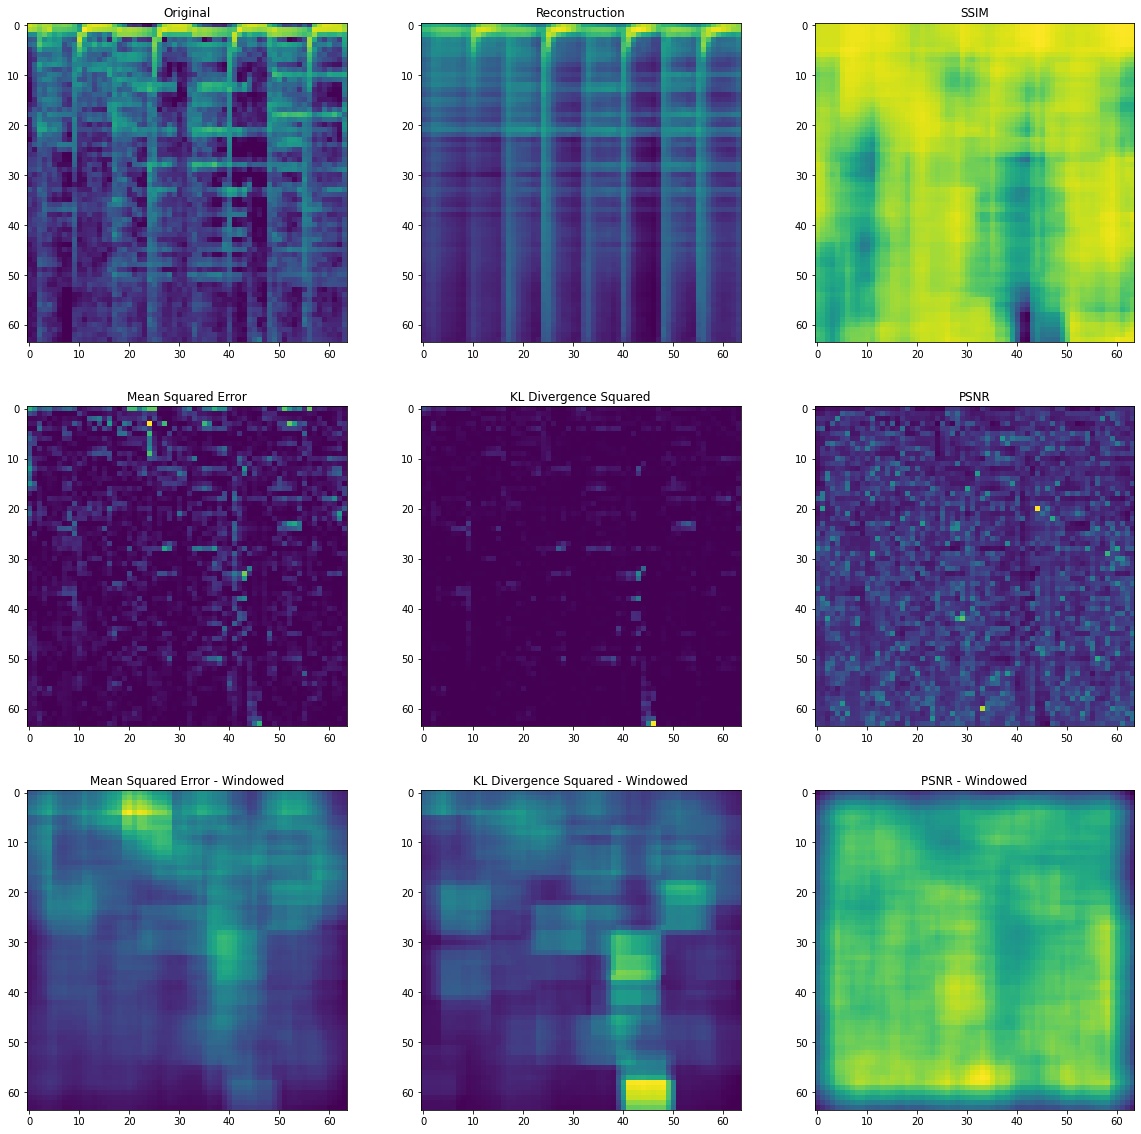

In [27]:
reconstruction_mse_window = autoencoder_mse_window(test_img)

evaluate_reconstruction(test_img, reconstruction_mse_window)

# Train Autoencoder using Windowed KL Divergence Squared

In [28]:
kld_window = WindowLoss(input_shape=input_shape, loss_function=kl_divergence_squared)
autoencoder_kld_window = build_autoencoder(latent_dim=latent_dimensions, 
                                    filters=convolutional_filters, 
                                    final_image_shape=encoded_image_shape, 
                                    loss=kld_window)


In [29]:
autoencoder_kld_window.fit(train_adg.train, epochs=10, validation_data=train_adg.test)

Epoch 1/10
3200/3200 [==============================] - 292s 91ms/step - loss: 0.0060 - mean_squared_error: 0.0333 - kl_divergence_squared: 0.0067 - ssim: 0.6958 - val_loss: 0.0054 - val_mean_squared_error: 0.0212 - val_kl_divergence_squared: 0.0060 - val_ssim: 0.7473
Epoch 2/10
3200/3200 [==============================] - 287s 90ms/step - loss: 0.0051 - mean_squared_error: 0.0220 - kl_divergence_squared: 0.0057 - ssim: 0.7193 - val_loss: 0.0049 - val_mean_squared_error: 0.0131 - val_kl_divergence_squared: 0.0055 - val_ssim: 0.7355
Epoch 3/10
3200/3200 [==============================] - 339s 106ms/step - loss: 0.0049 - mean_squared_error: 0.0197 - kl_divergence_squared: 0.0054 - ssim: 0.7263 - val_loss: 0.0050 - val_mean_squared_error: 0.0141 - val_kl_divergence_squared: 0.0055 - val_ssim: 0.7334
Epoch 4/10
3200/3200 [==============================] - 357s 111ms/step - loss: 0.0048 - mean_squared_error: 0.0185 - kl_divergence_squared: 0.0053 - ssim: 0.7301 - val_loss: 0.0047 - val_mean

Mean Squared Error 0.016768359
KL Divergence Squared 0.006382274
SSIM 0.85948384
PSNR 24.011164


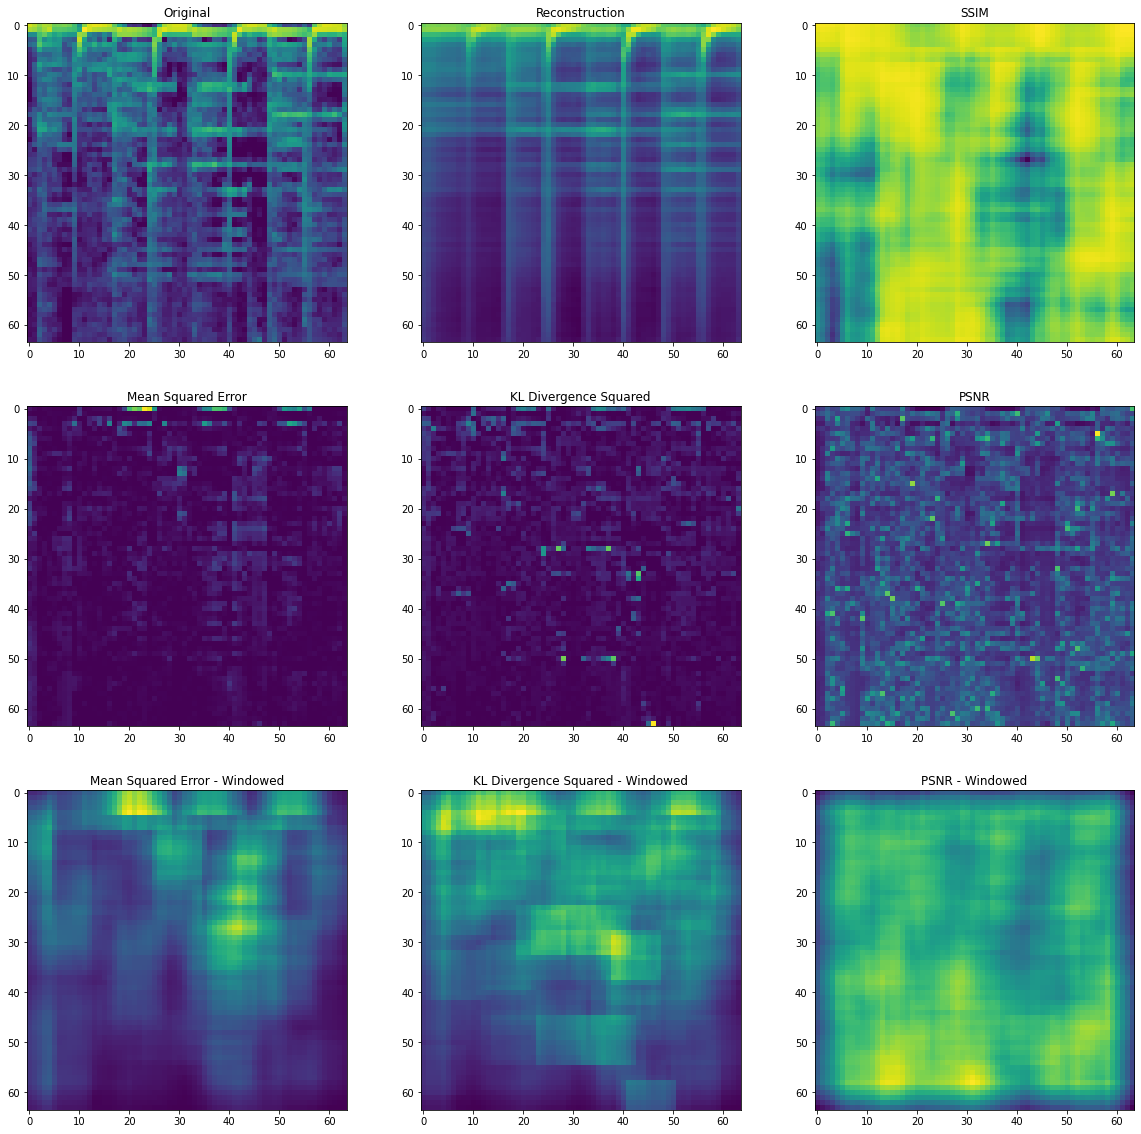

In [30]:
reconstruction_kld_window = autoencoder_kld_window(test_img)

evaluate_reconstruction(test_img, reconstruction_kld_window)

# Train Autoencoder using Windowed PSNR

In [31]:
psnr_window = WindowLoss(input_shape=input_shape, loss_function=kl_divergence_squared)
autoencoder_psnr_window = build_autoencoder(latent_dim=latent_dimensions, 
                                    filters=convolutional_filters, 
                                    final_image_shape=encoded_image_shape, 
                                    loss=psnr_window)


In [32]:
autoencoder_psnr_window.fit(train_adg.train, epochs=10, validation_data=train_adg.test)

Epoch 1/10
3200/3200 [==============================] - 287s 90ms/step - loss: 0.0060 - mean_squared_error: 0.0350 - kl_divergence_squared: 0.0066 - ssim: 0.6965 - val_loss: 0.0053 - val_mean_squared_error: 0.0141 - val_kl_divergence_squared: 0.0059 - val_ssim: 0.7430
Epoch 2/10
3200/3200 [==============================] - 284s 89ms/step - loss: 0.0051 - mean_squared_error: 0.0231 - kl_divergence_squared: 0.0057 - ssim: 0.7199 - val_loss: 0.0128 - val_mean_squared_error: 0.0146 - val_kl_divergence_squared: 0.0139 - val_ssim: 0.7358
Epoch 3/10
3200/3200 [==============================] - 284s 89ms/step - loss: 0.0049 - mean_squared_error: 0.0203 - kl_divergence_squared: 0.0055 - ssim: 0.7251 - val_loss: 0.0048 - val_mean_squared_error: 0.0146 - val_kl_divergence_squared: 0.0054 - val_ssim: 0.7510
Epoch 4/10
3200/3200 [==============================] - 285s 89ms/step - loss: 0.0048 - mean_squared_error: 0.0184 - kl_divergence_squared: 0.0053 - ssim: 0.7317 - val_loss: 0.0052 - val_mean_s

Mean Squared Error 0.016009234
KL Divergence Squared 0.0064579966
SSIM 0.8636848
PSNR 24.113516


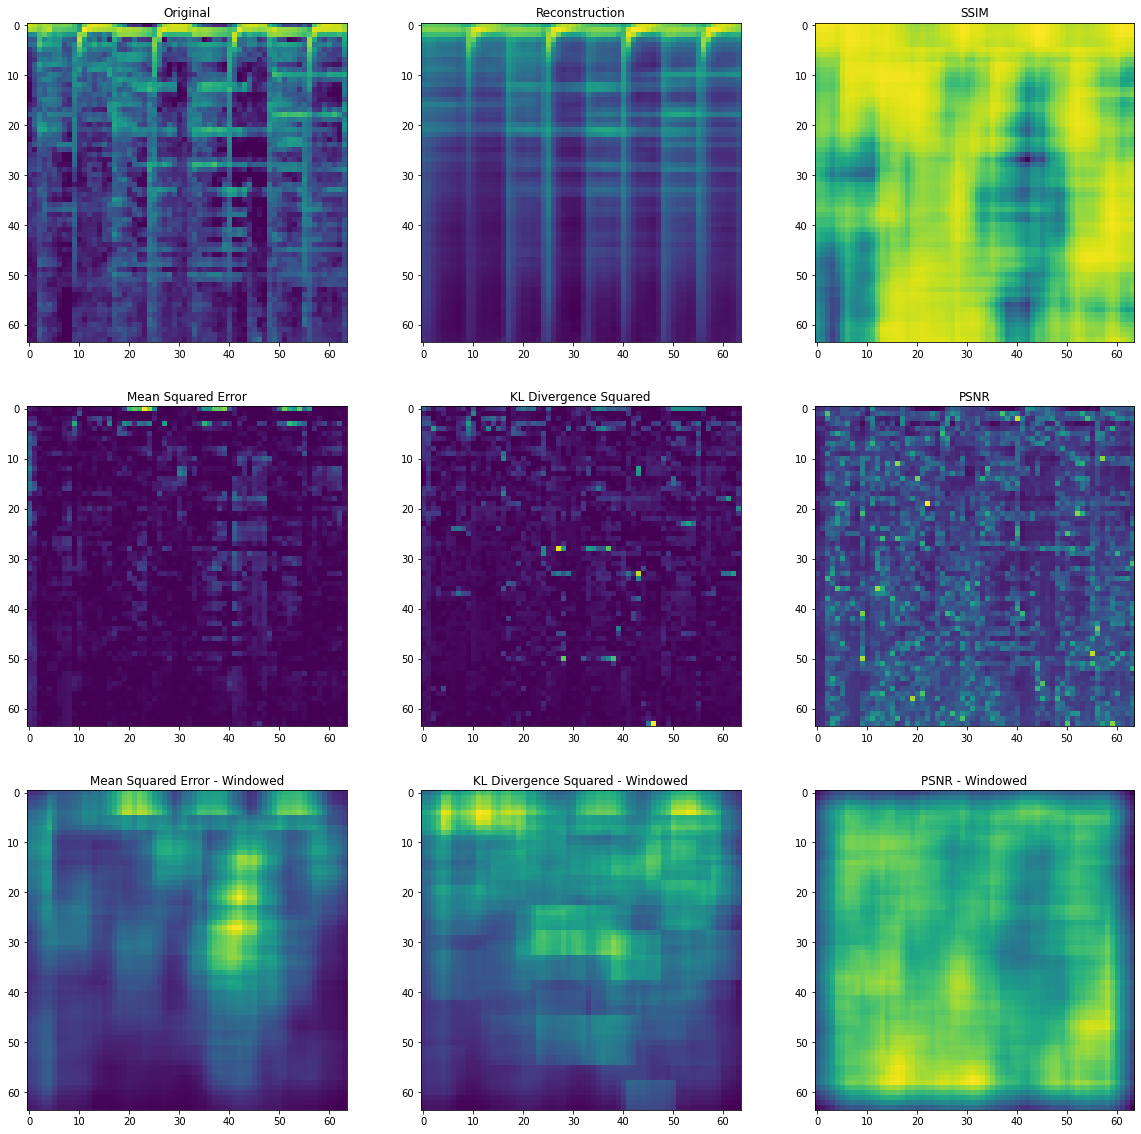

In [33]:
reconstruction_psnr_window = autoencoder_psnr_window(test_img)

evaluate_reconstruction(test_img, reconstruction_psnr_window)

# Train Autoencoder using Combined Loss

In [34]:
class CombinedLoss(tf.keras.losses.Loss):
    
    def __init__(self, input_shape, mse_factor, kl_factor, ssim_factor, kernel_size=10):
        super().__init__()
        
        self.input_shape = input_shape
        self.mse_factor = mse_factor
        self.kl_factor = kl_factor
        self.ssim_factor = ssim_factor
        self.kernel_size = kernel_size
        self.conv_layer = layers.Conv2D(filters=1, kernel_size=kernel_size, strides=1, padding='same', kernel_initializer=tf.keras.initializers.ones)

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, y_pred.dtype)
        y_true = k.reshape(y_true, shape=self.input_shape)
        y_pred = k.reshape(y_pred, shape=self.input_shape)

        
        mse_loss = self.mse_factor * mean_squared_error(y_true, y_pred)
        kl_loss = self.kl_factor * kl_divergence_squared(y_true, y_pred)
        combined = self.conv_layer(tf.expand_dims(mse_loss + kl_loss, axis=-1)) / self.kernel_size**2
        
        #have to build ssim from scratch in here, unless have to run in eager execution
        mu_1 = self.conv_layer(y_true) / self.kernel_size**2
        mu_2 = self.conv_layer(y_pred) / self.kernel_size**2
        
        mu1_sq = tf.math.square(mu_1)
        mu2_sq = tf.math.square(mu_2)
        mu1_mu2 = mu_1*mu_2
        
        sigma1_sq = self.conv_layer(y_true**2) - mu1_sq
        sigma2_sq = self.conv_layer(y_pred**2) - mu2_sq
        sigma_12 = self.conv_layer(y_pred*y_true) - mu1_mu2
        
        #scale ssim from 0 to 1, instead of -1 to 1, 0 is better correlation
        ssim = -0.5*((2*mu1_mu2 + 0.0001)*(2*sigma_12 + 2.7e-08))/((mu1_sq + mu2_sq + 0.0001)*(sigma1_sq + sigma2_sq + 2.7e-08))+0.5
        
        combined += self.ssim_factor * ssim
        combined /= self.mse_factor + self.kl_factor + self.ssim_factor
            
        return combined
    
    def preview(self, y_true, y_pred):
        
        return self.call(y_true, y_pred)

In [35]:
combined_loss = CombinedLoss(input_shape=input_shape, 
                             mse_factor=1, 
                             kl_factor=1, 
                             ssim_factor=1)

autoencoder_combined = build_autoencoder(latent_dim=latent_dimensions, 
                                    filters=convolutional_filters, 
                                    final_image_shape=encoded_image_shape, 
                                    loss=combined_loss)


In [36]:
autoencoder_combined.fit(train_adg.train, epochs=10, validation_data=train_adg.test)

Epoch 1/10
3200/3200 [==============================] - 410s 128ms/step - loss: 0.0396 - mean_squared_error: 0.0134 - kl_divergence_squared: 0.0110 - ssim: 0.8053 - val_loss: 0.0435 - val_mean_squared_error: 0.0119 - val_kl_divergence_squared: 0.0254 - val_ssim: 0.8041
Epoch 2/10
3200/3200 [==============================] - 408s 127ms/step - loss: 0.0306 - mean_squared_error: 0.0099 - kl_divergence_squared: 0.0093 - ssim: 0.8505 - val_loss: 0.0299 - val_mean_squared_error: 0.0091 - val_kl_divergence_squared: 0.0108 - val_ssim: 0.8562
Epoch 3/10
3200/3200 [==============================] - 412s 129ms/step - loss: 0.0288 - mean_squared_error: 0.0094 - kl_divergence_squared: 0.0089 - ssim: 0.8598 - val_loss: 0.0326 - val_mean_squared_error: 0.0090 - val_kl_divergence_squared: 0.0100 - val_ssim: 0.8380
Epoch 4/10
3200/3200 [==============================] - 406s 127ms/step - loss: 0.0278 - mean_squared_error: 0.0092 - kl_divergence_squared: 0.0086 - ssim: 0.8647 - val_loss: 0.0271 - val_me

Mean Squared Error 0.013310499
KL Divergence Squared 0.012122607
SSIM 0.9059102
PSNR 25.447601


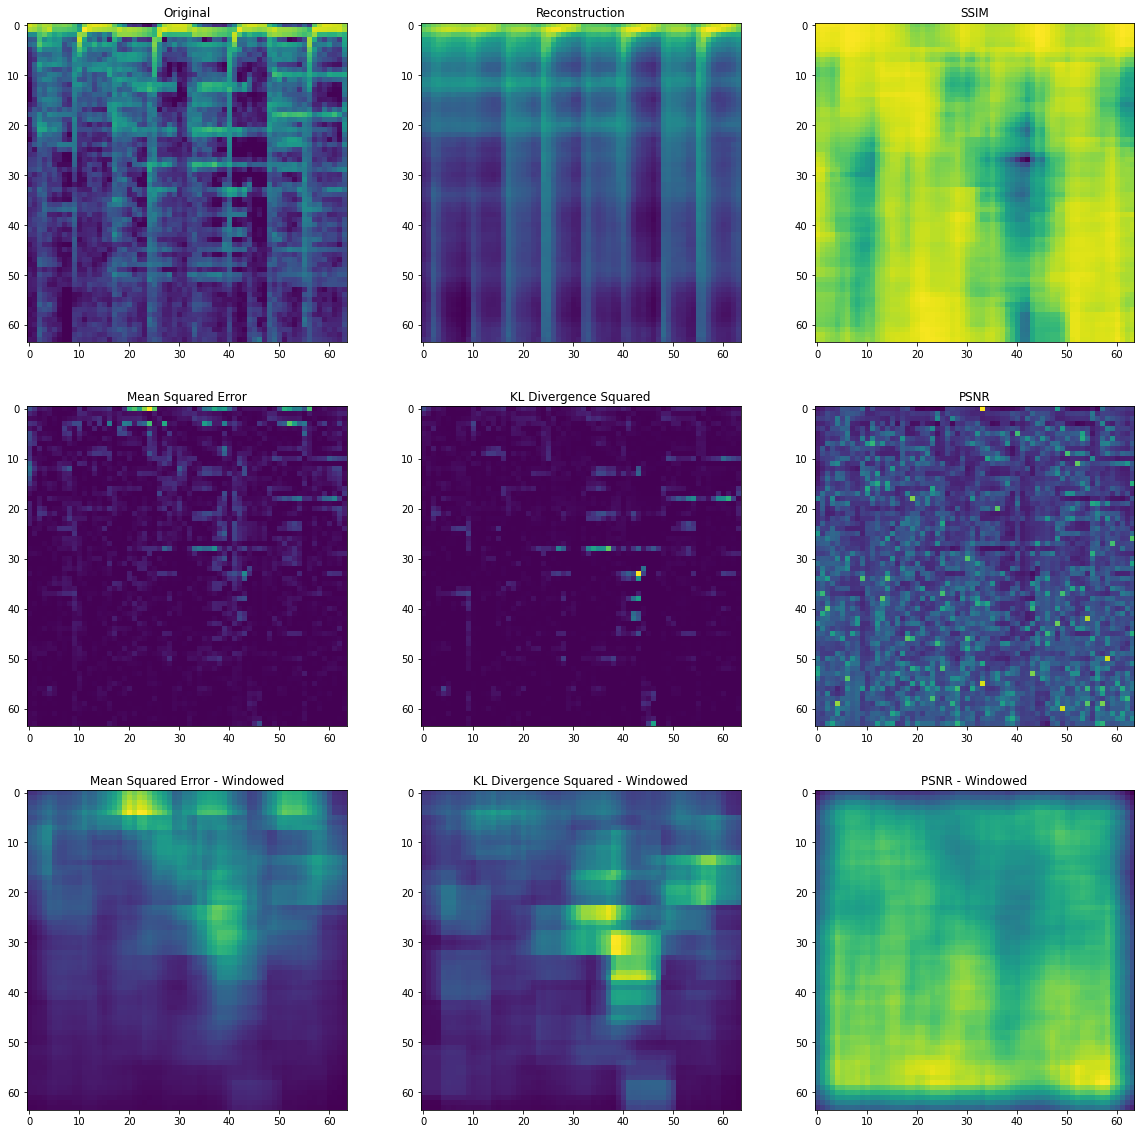

In [37]:
reconstruction_combined = autoencoder_combined(test_img)

evaluate_reconstruction(test_img, reconstruction_combined)

# Analyze Combined Loss for each Autoencoder

mse 0.021303976
kld 0.03370884
ssim 0.024369888
mse_window 0.020799272
kld_window 0.030210095
psnr_window 0.029333616
combined 0.02328082


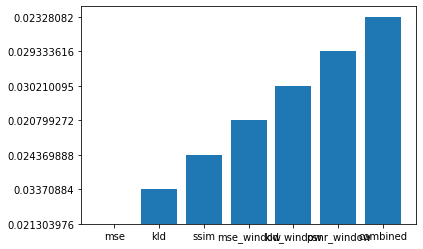

In [38]:
combined_loss_test = CombinedLoss(input_shape=test_img.shape, mse_factor=1, kl_factor=1, ssim_factor=1)

combined_losses = []
combined_losses.append(('mse', combined_loss_test(test_img, autoencoder_mse(test_img)).numpy()))
combined_losses.append(('kld', combined_loss_test(test_img, autoencoder_kld(test_img)).numpy()))
combined_losses.append(('ssim', combined_loss_test(test_img, autoencoder_ssim(test_img)).numpy()))
combined_losses.append(('mse_window', combined_loss_test(test_img, autoencoder_mse_window(test_img)).numpy()))
combined_losses.append(('kld_window', combined_loss_test(test_img, autoencoder_kld_window(test_img)).numpy()))
combined_losses.append(('psnr_window', combined_loss_test(test_img, autoencoder_psnr_window(test_img)).numpy()))
combined_losses.append(('combined', combined_loss_test(test_img, autoencoder_combined(test_img)).numpy()))


combined_losses = np.array(combined_losses)

for result in combined_losses:
    print(result[0], result[1])
    
plt.bar(combined_losses[:,0],combined_losses[:,1])
plt.show()


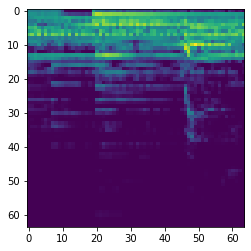

mel_autoencoder_1


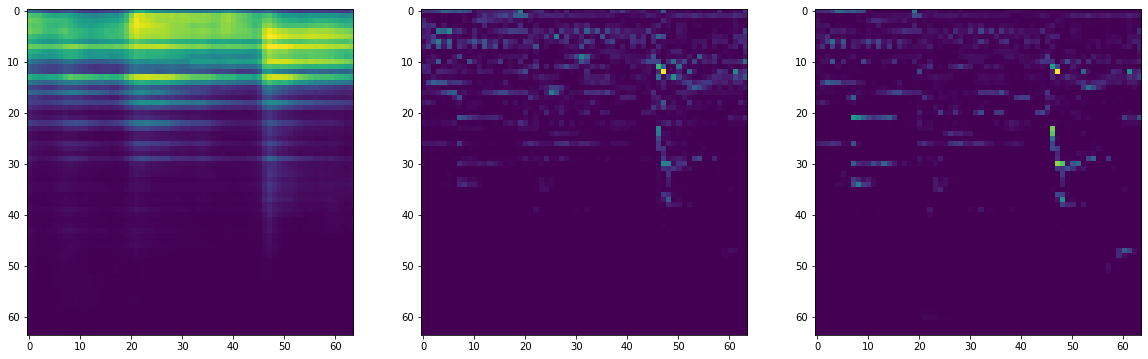

mel_autoencoder_2


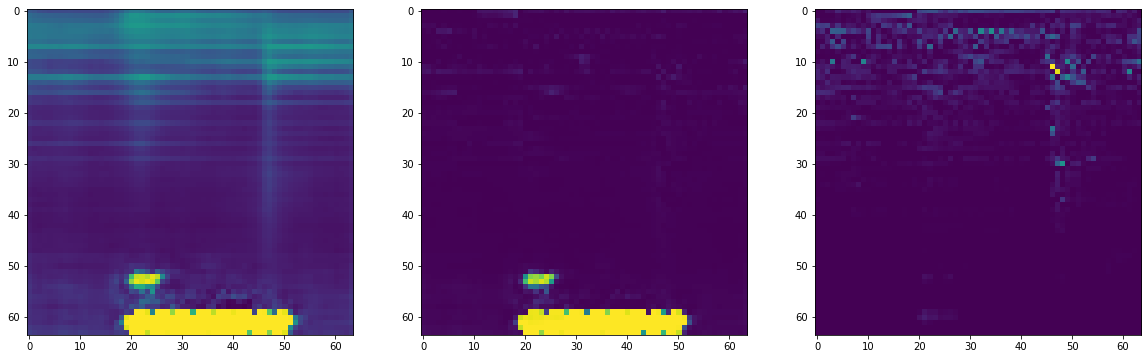

mel_autoencoder_3


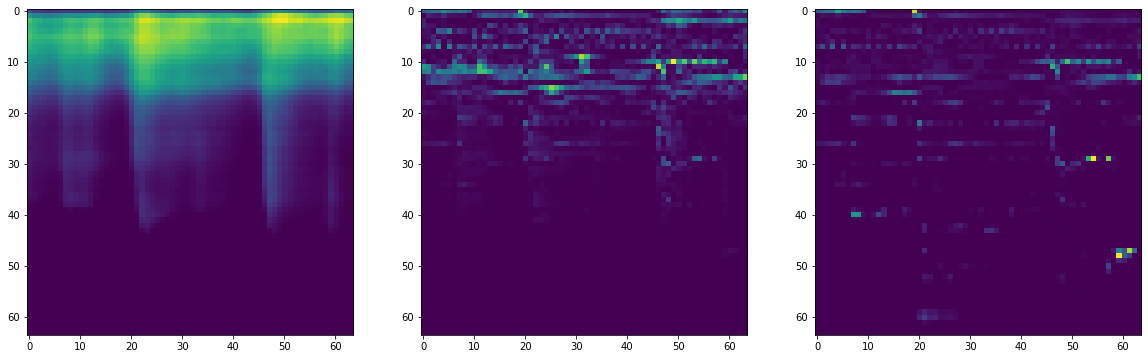

mel_autoencoder_4


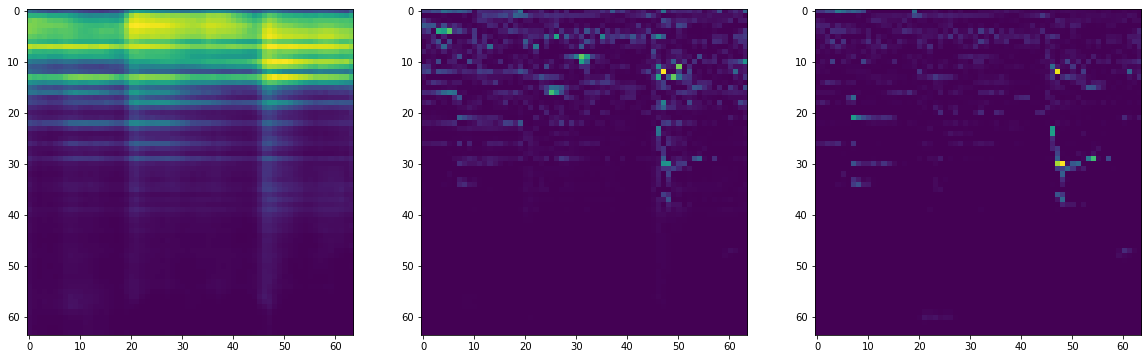

mel_autoencoder_5


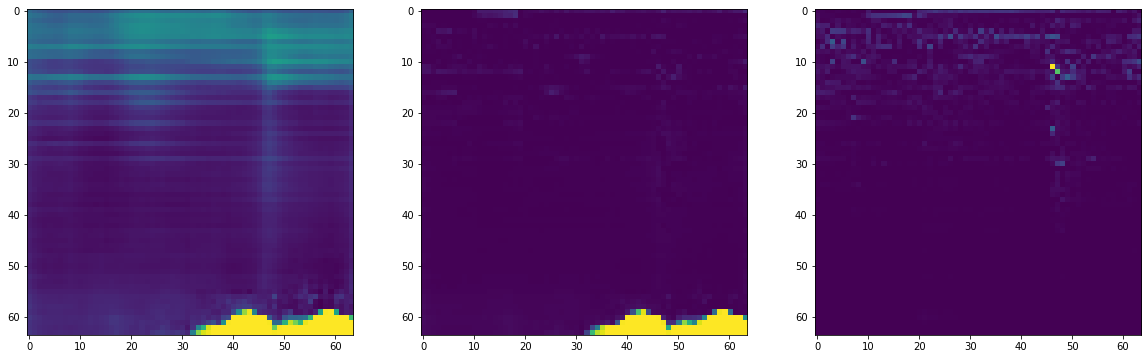

mel_autoencoder_6


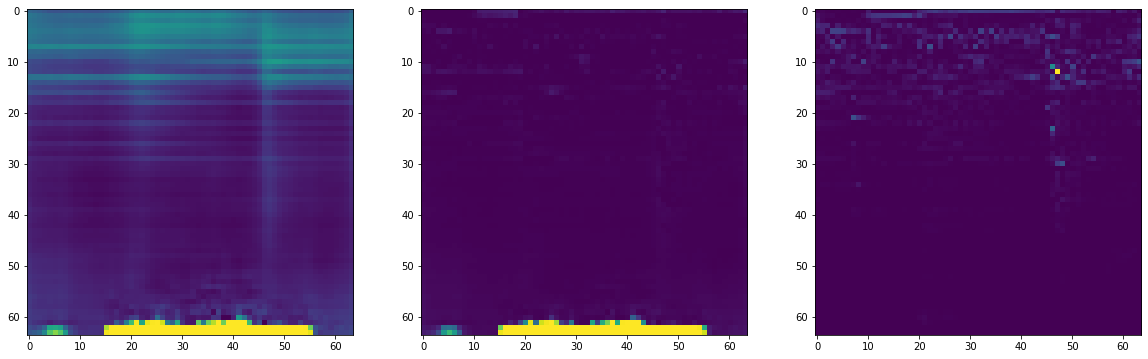

mel_autoencoder_7


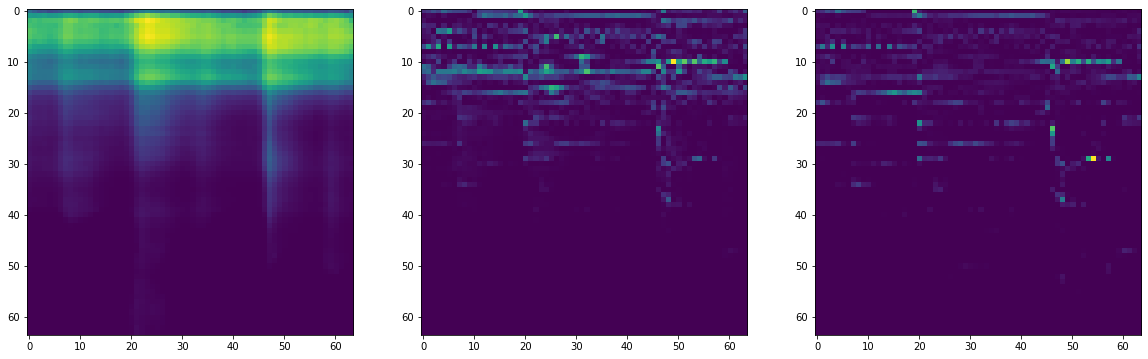

In [69]:
index = 134
models = [autoencoder_mse, 
          autoencoder_kld, 
          autoencoder_ssim, 
          autoencoder_mse_window, 
          autoencoder_kld_window, 
          autoencoder_psnr_window, 
          autoencoder_combined
         ]
test_img = adg.take(index)[0]

plt.imshow(test_img[0])
plt.show()
for model in models:
    print(model.name)
    fig, ax = plt.subplots(ncols=3, figsize=(20,6))
    ax[0].imshow(model(test_img)[0])
    ax[1].imshow(mean_squared_error(test_img, model(test_img))[0])
    ax[2].imshow(kl_divergence_squared(test_img, model(test_img))[0])
    plt.show()